In [270]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:

from src.catalogs import (
    JapanSlowSlipCatalog,
    MexicoSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog,   # too few earthquakes to estaplish rate changes 
    OkadaAlaskaSlowSlipCatalog,
)

from src.data import (
    AllSlabs, 
    Catalog,
    EarthquakeCatalog,
    Scaling,
)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde, kstest

from typing import Union

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

dpi = 100
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=12)
figure_save_dir = base_dir/'Docs'/'Figures_SCEC'
save_figures = True
def savefig(fig_name, save_fig_bool = save_figures):
    plt.savefig(figure_save_dir/f'{fig_name}.pdf', transparent=True,bbox_inches='tight')

# Global analysis of slow slip

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

In [3]:
all_slabs = AllSlabs()

`EarthquakeCatalog` loads the global Comcat catalog. The first time running this will take a long time (a few minutes).

In [352]:
minimum_magnitude = 4.0

metadata = {
    "starttime": '1994-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude":minimum_magnitude 
}

earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes.csv",
    kwargs=metadata,
)

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 486 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [448]:
DEPTH_SUBSET = 'all'
assert DEPTH_SUBSET in ['deep','shallow','all']

DURATION_SUBSET = 'all'
assert DURATION_SUBSET in ['short term', 'long term', 'all']

SLOWSLIP_MAGNITUDE_CUTOFF = 6.0
assert type(SLOWSLIP_MAGNITUDE_CUTOFF) is float

# Duplicate filtering
DUPLICATE_RADIUS = 70
DUPLICATE_TIME = 40

# Spatio-temporal emporal analysis:
TIME_WINDOW = 2*365 # days
SMOOTHING_BANDWIDTH_DAYS = 5 # days

SPACE_WINDOW_BIG = 2000 # km for spatial stack
DISTANCE_TO_SLAB = 20 # km 

REPRESENTATIVE_SSE_DURATION = 14 # days
REPRESENTATIVE_SSE_SIZE = 50 # km for temporal stack

BUFFER_TIME = REPRESENTATIVE_SSE_DURATION

BACKGROUND_DURATION = 2*365

MIN_NUMBER_OF_EVENTS_FOR_RATE_CHANGE = 4


## Slow slip datasets and pre-processing

* depth 
* duration
* magnitude
* duplicates

In [449]:
# Consider depth subsets THIS CURRENTLY RELOADS THE DATA!!
if DEPTH_SUBSET == 'shallow':
    shallow_slowslip = [
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[0],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[0],
        XieSlowSlipCatalog().get_clusters('depth',2)[0],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[0],
        OkadaAlaskaSlowSlipCatalog.get_clusters('depth',2)[0],
    ]

    [plt.hist(c.catalog.depth, bins=np.linspace(0,80,40), label=c.name) for c in shallow_slowslip];
    plt.legend()


    slowslip = shallow_slowslip

elif DEPTH_SUBSET == 'deep':
    deep_slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[1],
        MexicoSlowSlipCatalog(), 
        XieSlowSlipCatalog().get_clusters('depth',2)[1],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[1],
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog.get_clusters('depth',2)[1],
    ]
    
    [plt.hist(c.catalog.depth, bins=np.linspace(0,80,40), label=c.name) for c in deep_slowslip];
    plt.legend()


    slowslip = deep_slowslip

elif DEPTH_SUBSET == 'all':
    slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough(),
        JapanSlowSlipCatalog().get_ryukyu_trench(),
        JapanSlowSlipCatalog().get_japan_trench(),
        MexicoSlowSlipCatalog(), 
        XieSlowSlipCatalog(),
        WilliamsSlowSlipCatalog(),
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog(),
    ]
        
# Consider magnitude cutoff
for ss in slowslip:
    ss.mag_completeness = SLOWSLIP_MAGNITUDE_CUTOFF # changing in place


# Consider different duration types of SSEs
if DURATION_SUBSET == 'short term':
    slowslip = [ss.get_short_term_events() for ss in slowslip]
elif DURATION_SUBSET == 'long term':
    slowslip = [ss.get_long_term_events() for ss in slowslip] 

slowslip = [ss for ss in slowslip if len(ss)>0]
all_slowslip = sum(slowslip[1:], slowslip[0])

# Consider unique events
filter_kwargs = dict(
    buffer_radius_km = DUPLICATE_RADIUS,
    buffer_time_days = DUPLICATE_TIME,
    stategy='reference',
)

all_slowslip = all_slowslip.filter_duplicates(
    **filter_kwargs,
    ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index
)

slowslip_filtered = []
for s in slowslip:
    slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))

slowslip = slowslip_filtered
slowslip = sorted(slowslip, key=lambda x: len(x), reverse=True)
for s in slowslip:
    s.catalog['name'] = s.name 
    s.catalog['region'] = s.region
all_slowslip = sum(slowslip[1:], slowslip[0])

In [450]:
print("Depth clusters (km):")
[print(np.mean(c.catalog.depth)) for c in all_slowslip.get_clusters('depth',3)];

Depth clusters (km):
11.018103984737499
28.562402794872412
46.30281683994486


Chen et al. (2018)
Cruz-Atienza et al. (2021)
El Yousfi et al. (2022)
Graham et al. (2016)
Itaba et al. (2013b)
Ito et al. (2013)
Kostoglodov (2003)
Lou et al. in prep.
Lowry et al. (2001)
Michel et al. 2018
Nishimura (2013)
Nishimura (2014)
Nishimura (2021)
Ochi et al. (2015)
Okada et al. (2022)
Okada et al. (2023)
Radiguet et al. (2011)
Radiguet et al. (2016)
Rousset et al. 2017
Sekine et al. (2010)
Takagi et al. (2016)
Takagi et al. (2022)
Williams et al., in prep.
Xie et al. (2020)
Yano and Kano (2022)


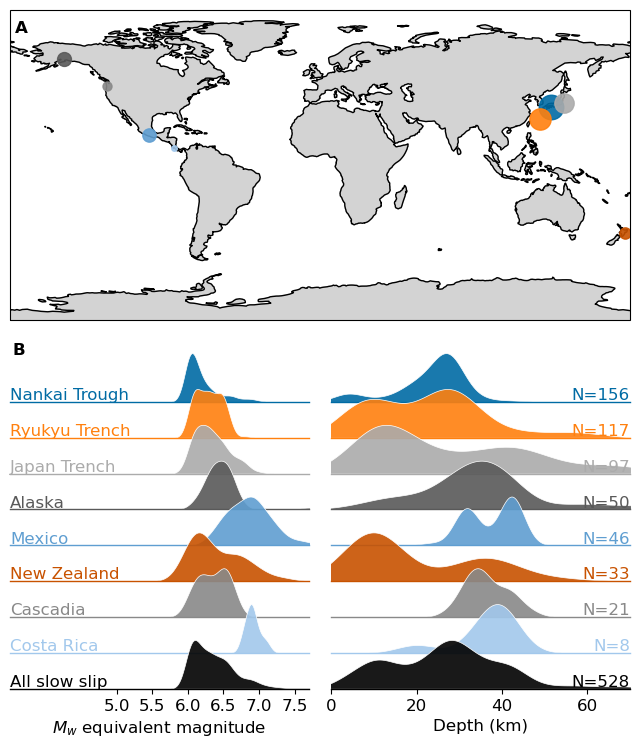

In [451]:
fig = plt.figure(figsize=(8,9))

gs0 = mpl.gridspec.GridSpec(2, 1,  hspace=0.05)

# Map:
ax0 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())
extent = [-180,180,-90,90]
ax0.set_extent(extent,crs=ccrs.PlateCarree(),)
ax0.add_feature(cfeature.LAND, color="lightgray")
# ax0.add_feature(cfeature.OCEAN)
ax0.add_feature(cfeature.COASTLINE)

for i_slowslip in slowslip:
    ax0.scatter(
        np.mean(i_slowslip.catalog.lon),
        np.mean(i_slowslip.catalog.lat),
        s=len(i_slowslip)*2,
        edgecolors=None,
        label=f"N={len(i_slowslip)}, {i_slowslip.name}",
        zorder=10,
        alpha=0.9
    )

# Two colomns of ridgelin plots:
gs01 = mpl.gridspec.GridSpecFromSubplotSpec(len(slowslip)+1, 2, subplot_spec=gs0[1], hspace=-0.3, wspace=0.075)

def clean_ax(ax):
    ax.set(
        yticks=[],
        xticks=[],
        ylabel='',
        xlabel='',
        xticklabels=[],
    )
    rect = ax.patch
    rect.set_alpha(0)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax.spines[s].set_visible(False)

mag_AX = []
depth_AX = []
for i,ss in enumerate(slowslip+[all_slowslip]):
    shared_kwargs = dict(
        data=ss.catalog,
        color=f"C{i}" if i<len(slowslip) else 'k',
        linewidth=0.5,
        edgecolor='w',
        alpha=0.9,
        clip_on=True,
        fill=True,
    )

    mag_AX.append(fig.add_subplot(gs01[i, 0]))
    ax = mag_AX[-1]
    
    sns.kdeplot(
        x='mag',
        **shared_kwargs,
        ax=ax,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)

    ax.set_xlim(3.5,max(all_slowslip.catalog.mag))

    
    depth_AX.append(fig.add_subplot(gs01[i, 1]))
    ax = depth_AX[-1]
    
    sns.kdeplot(
        x='depth',
        ax=ax,
        **shared_kwargs,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)
    ax.set_xlim(0,70)
    
    [clean_ax(ax) for ax in [mag_AX[-1], depth_AX[-1]]]    


for i in range(len(slowslip)+1):
    ax = mag_AX[i]
    ax.text(
        0, 
        0.04, 
        slowslip[i].region if i<len(slowslip) else 'All slow slip', 
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='left'
    )
    
    ax = depth_AX[i]
    ax.text(        
        1, 
        0.04,
        f"N={len(slowslip[i])}" if i<len(slowslip) else f"N={len(all_slowslip)}",
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='right'
    )
    
ax = depth_AX[-1]
xticks = [0,20,40,60]
ax.set(xticks=xticks, xticklabels=xticks, xlabel='Depth (km)')

ax = mag_AX[-1]
xticks = np.arange(5,8,0.5)
ax.set(xticks=xticks, xticklabels=xticks, xlabel='$M_w$ equivalent magnitude');

for n, ax in enumerate([ax0,mag_AX[0]]):
    pos = [0.008, 0.925]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('global_map')

[print(ref) for ref in all_slowslip.catalog.ref.sort_values().unique()];

## Analysis

In [452]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=SPACE_WINDOW_BIG)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < DISTANCE_TO_SLAB])

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/slab2.py:138: UserWarning: xyz contains negative depths
  warnings.warn("xyz contains negative depths")


## Global stacking

### Time stacks

In [453]:
def center_sequences(
    slowslipevents: Catalog = all_slowslip,
    earthquakes: Catalog = local_earthquakes,
    time_window: Union[float,np.ndarray] = TIME_WINDOW,
    space_window: float = REPRESENTATIVE_SSE_SIZE,
    lag = 0,
    slab_model=all_slabs,
    concatenate_output: bool = True,
    return_indices: bool = False,
):
        
    return src.center_sequences(
        slowslipevents,
        earthquakes,
        time_window,
        space_window,
        lag,
        slab_model,
        concatenate_output,
        return_indices,
    )

In [454]:
def get_p_relative_to_back(
    slowslipevents = all_slowslip,
    earthquakes = local_earthquakes,
    event_duration = REPRESENTATIVE_SSE_DURATION,
    buffer_dutation = BUFFER_TIME,
    background_duration = BACKGROUND_DURATION,
    radius_km = REPRESENTATIVE_SSE_SIZE, 
    return_time_lags = True,
    number_samples = 1000,
):

    T_event = event_duration
    buffer = buffer_dutation
    T_pre = background_duration 
    R = radius_km

    pre_time_lags, buffer_time_lags, co_time_lags = [
        center_sequences(slowslipevents, earthquakes, time_window=T,space_window=R,lag=L, concatenate_output=False)[0]
        for T, L in zip(
            [T_pre, buffer, T_event],
            [-T_pre/2 - T_event/2 - buffer, -T_event/2-buffer/2, 0],
        )
    ]

    p_values = []

    for pre, co in zip(pre_time_lags, co_time_lags):
        N_baseline = []
        
        for _ in range(number_samples):
            random_window_start_time = np.random.uniform(
                -T_pre - T_event/2 - buffer,
                -T_event/2 - buffer - T_event # -T_event because we want to avoid the event itself
            )
            
            # count number times in pre that are in the range [random_window_start_time, random_window_start_time + T_event]
            N_baseline.append(
                np.sum(
                    (pre > random_window_start_time) & (pre < random_window_start_time + T_event)
                )
            )
        eps = 0 # perturb the baseline by a small amount such that window is the same number of events are divied up equally
        p_values.append(
            np.mean(
                len(co) <= np.array(N_baseline)  + np.random.uniform(-eps,eps,len(N_baseline))
            )
        )

    p_values = np.array(p_values)
    
    if return_time_lags:
        return p_values, pre_time_lags, buffer_time_lags, co_time_lags
    else:
        return p_values

## Temporal stacking

In [455]:
time_window = TIME_WINDOW # days

# lazy way of doing this...
raw_global_relative_times, raw_global_relative_distances, raw_global_weights, raw_global_Indices = center_sequences(time_window=time_window, concatenate_output=False, return_indices=True)
global_relative_times, global_relative_distances, global_weights = center_sequences(time_window=time_window)


regional_relative_times = []
regional_relative_distances = []
regional_weights = []
regionalized_weights = []
regional_window_indices = []

for region in slowslip:
    dt, dx, w, I = center_sequences(region,time_window=time_window, return_indices=True)
    regional_relative_times.append(dt)
    regional_relative_distances.append(dx)
    regional_weights.append(w)
    regionalized_weights.append(w/len(w))
    regional_window_indices.append(I)
    
combined_regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)
    

In [456]:
regional_jackknife = []
bw = 0.05
number_of_times = 1000
time_array = np.linspace(-time_window/2, time_window/2, number_of_times)
for i in range(len(slowslip)):
    i_slowslip = [sse for n,sse in enumerate(slowslip) if n != i] # all but the ith slow slip event
    dt, dx, w = center_sequences(sum(i_slowslip[1:],i_slowslip[0]),time_window=time_window)
    regional_jackknife.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)
    )

p = []
for i_slowslip in slowslip:
    p_values = get_p_relative_to_back(i_slowslip, return_time_lags=False)
    p.append((np.log10(np.mean(p_values<0.05)/0.05)/1.5 + 0.5))

In [457]:
def add_gbar(ax,v, cmap='RdBu_r'):
    cax = ax.inset_axes([0.01, 0.7, 0.2, 0.2])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, cax=cax, orientation='horizontal', fraction=1, aspect=20)
    cb.ax. plot(v,0.5, 'k', marker='o',markersize=2.5)
    cb.ax.set(
        xticks=[],
    )
    return cb

Text(0.5, 0, 'Number of earthquakes in slow slip window')

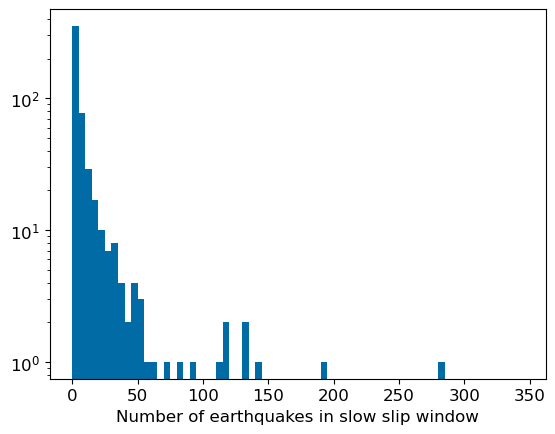

In [458]:
counts = np.array([len(s) for s in raw_global_relative_times])
bins = np.arange(0,350,5)
plt.hist(counts, log=True,bins=bins)
plt.xlabel('Number of earthquakes in slow slip window')


In [459]:
def in_vs_out(n_samples = 1000, sse=all_slowslip, t=raw_global_relative_times, T=TIME_WINDOW, buffer=30):
    N_SSE = []
    N_0 = []
    r = []

    for _ in range(n_samples):
        I = np.random.randint(len(t))
        i_window = t[I]
        i_duration_days = sse.catalog.duration.values[I]/60/60/24
        
        if np.isnan(i_duration_days) or i_duration_days<=5:
            i_duration_days = 10 # impute reasonable duration
        
        if not i_duration_days < T/2 - buffer - i_duration_days/2: # must fit in the study window
            continue
        
        t0_rand = 0
        i_N_SSE =np.sum((i_window< t0_rand + i_duration_days/2) & (i_window> t0_rand - i_duration_days/2))
        t0_rand = np.random.uniform(-T/2+i_duration_days/2, - i_duration_days)
        i_N_0 =  np.sum((i_window< t0_rand + i_duration_days/2) & (i_window> t0_rand - i_duration_days/2))

        if (i_N_SSE + i_N_0) < MIN_NUMBER_OF_EVENTS_FOR_RATE_CHANGE:
            continue
        
        N_SSE.append(i_N_SSE)
        N_0.append(i_N_0)
        
        r.append(
            i_N_SSE/(i_N_SSE+i_N_0)
        )
        
        # fig, ax = plt.subplots(figsize=(10,2))
        # sns.rugplot(i_window, ax=ax, height=1, lw=1,alpha = 1)
        # ax.axvspan(-i_duration_days/2, i_duration_days/2, alpha=0.3,facecolor='r')
        # ax.axvspan(t0_rand + i_duration_days/2, t0_rand - i_duration_days/2, alpha=0.3, facecolor='g')
        # ax.set(
        #     xlim=[-T/2,T/2],
        # )
        # ax.legend([f'r: {r[-1]}, N_0: {i_N_0}, N_SSE: {i_N_SSE}'])

    return r, N_SSE, N_0

r, N_SSE, N_0 = in_vs_out()

In [460]:
windows = np.logspace(1,3,20)
R = []
F = []
ALPHA = []
for i_window in windows:
    r, n_sse, n_o = [np.array(l) for l in in_vs_out(t=center_sequences(space_window=i_window, concatenate_output=False)[0])]
    R.append(np.nanmean(r))
    
    f = np.log(n_sse) - np.log(n_o)
    f = f[~np.isnan(f) & ~np.isinf(f)]
    f = np.mean(f)
    f = np.exp(f)
    F.append(np.mean(f))
    
    n_o = n_o[:,np.newaxis]
    a = np.linalg.lstsq(n_o, n_sse,rcond=None)[0]
    
    ALPHA.append(a)

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/139626651.py:9: RuntimeWarning: divide by zero encountered in log
  f = np.log(n_sse) - np.log(n_o)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/139626651.py:7: RuntimeWarning: Mean of empty slice
  R.append(np.nanmean(r))
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/754039852.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.plot(windows[:len(F)],R/(1-R), label='r/(1-r)')


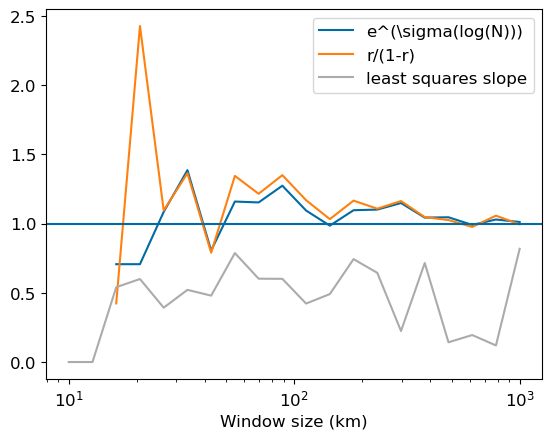

In [461]:
fig, ax = plt.subplots()
R = np.array(R)
# ax.plot(windows,R,c='k')

ax.plot(windows[:len(F)],F, label='e^(\sigma(log(N)))')
ax.plot(windows[:len(F)],R/(1-R), label='r/(1-r)')
ax.plot(windows[:len(F)],ALPHA,label='least squares slope')
ax.set(
    xscale='log',
    xlabel='Window size (km)',
)
ax.axhline(1)
ax.legend()

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/2151863655.py:13: RuntimeWarning: divide by zero encountered in divide
  f = np.array(N_SSE)/np.array(N_0)


1.7590524606971976
0.9952124797054064


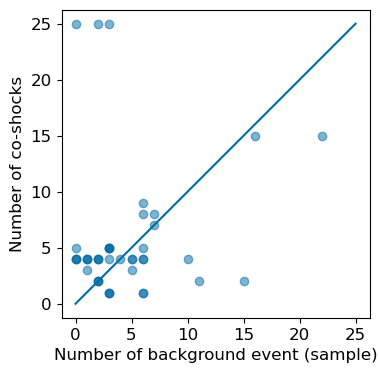

In [462]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(N_0,N_SSE, alpha=0.5,edgecolors=None)
ax.set(
    xlabel='Number of background event (sample)',
    ylabel='Number of co-shocks',
    aspect='equal'
)
minmax = [min(N_SSE+N_0),max(N_SSE+N_0)]
ax.plot(minmax,minmax)

np.polyfit(N_0, N_SSE,1)

f = np.array(N_SSE)/np.array(N_0)
f = f[~np.isinf(f) & ~np.isnan(f)]
print(np.mean(f))

mean_r = np.nanmean(r)
print(mean_r/(1-mean_r))

0.9952124797054064


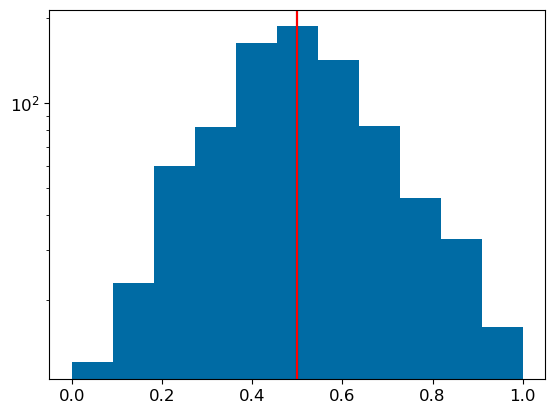

In [463]:
plt.hist(r,log=True, bins=11)
plt.axvline(0.5,c='k')
plt.axvline(np.mean(r),c='r')
Er = np.mean(r)
print(Er/(1-Er))

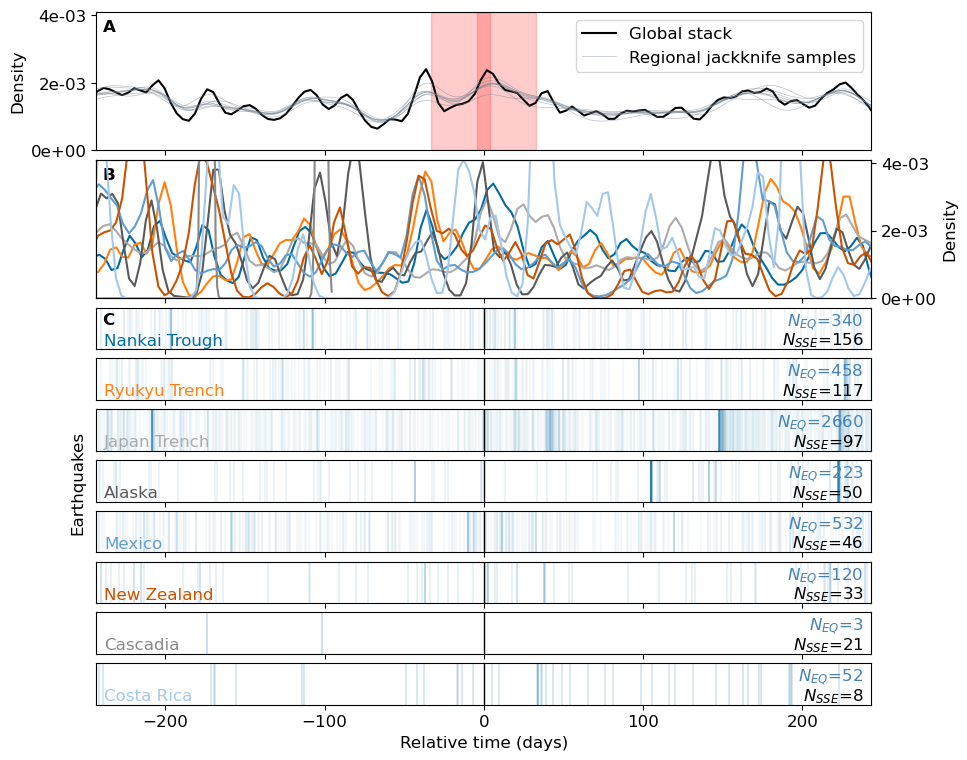

In [465]:
fig, AX = plt.subplots(len(slowslip)+2, 1, figsize=(10,9), sharex=True, gridspec_kw=dict(hspace=0.15, height_ratios=2*[1]+len(slowslip)*[0.3]))
data_std = np.std(global_relative_times)
smoothing_bandwidth = SMOOTHING_BANDWIDTH_DAYS
bw = smoothing_bandwidth/data_std


duration = all_slowslip.catalog['duration'].dropna().values/60/60/24
duration = duration[duration>0]
q = np.quantile(duration, [0.25,0.75])

# plot the 5, 50, and 95 percentile duration of the events
[
    AX[0].axvspan(-iq/2, iq/2, color='red', alpha=0.2)
    for iq in q
]

sns.kdeplot(
    x=global_relative_times,
    label=f"Global stack", 
    ax=AX[0],
    color='k',
    **dict(bw_method=bw, weights=global_weights)
)
lh = [
    AX[0].plot(time_array, regional_jackknife[i], color='slategray', lw=0.5, alpha=0.5) for i in range(len(slowslip))
]
lh[0][0].set_label('Regional jackknife samples')
AX[0].legend(loc='upper right')
AX[0].set(
    ylim=(0.000,3*1/TIME_WINDOW),
)
AX[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))


AX[1].set(yticks=[])
axb = AX[1].twinx()
for dt,w in zip(regional_relative_times, regional_weights):
    sns.kdeplot(
        x=dt,
        label=f"KDE bandwidth: {smoothing_bandwidth} days", 
        ax=axb,
        **dict(bw_method=bw, weights=w),
    )
axb.set(
    ylim=(0.0000,3*1/TIME_WINDOW),
)
axb.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))

for i, region, dt, i_window_indices, iax in zip(
    range(len(slowslip)), 
    slowslip, 
    regional_relative_times, 
    regional_window_indices, 
    AX[2:]
):
    sns.rugplot(dt, ax=iax, label=f'{region.name}', height=1, lw=0.3, alpha=min(1,5/np.sqrt(len(dt)))) 
    iax.set(
        yticks=[],
    )
    
    # calculate the seiscmic coupling?
    Mo_sse = (10**(3/2*region.catalog['mag']+9.1)).sum()
    
    unique_indices = np.unique(np.concatenate(i_window_indices))
    Mo_eq = (10**(3/2*local_earthquakes.catalog['mag'].values[unique_indices]+9.1)).sum()
    
    coupling = Mo_eq/(Mo_sse+Mo_eq)
    
    # iax.text(0.01,0.9,'$\chi_{SSE}$='+ f'{coupling:.2f}',transform=iax.transAxes, ha='left', va='top', color='indianred')
    iax.text(0.01,0.1,region.region,transform=iax.transAxes,color=f'C{i}')
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(dt)}",transform=iax.transAxes, ha='right', va='top', color='steelblue')
    iax.axvline(0, color='k', lw=1)


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-time_window/3,time_window/3],
)

AX[4].set_ylabel('Earthquakes', ha='right')

for n, ax in enumerate(AX[:3]):
    pos = [0.008, 0.86]
    if n==2:
        pos = [0.008, 0.6]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('stack')



Text(0.5, 0, 'Duration (days)')

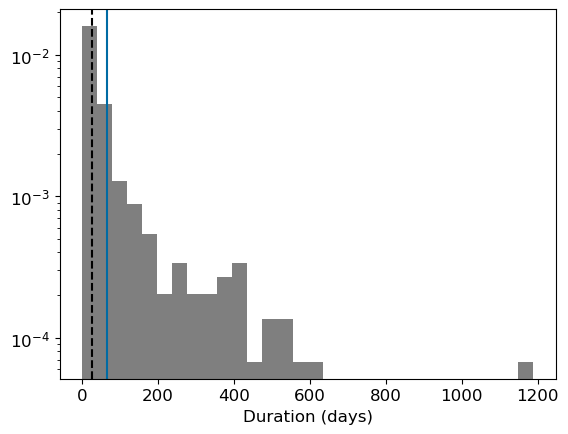

In [436]:
plt.hist(all_slowslip.catalog['duration'].values/60/60/24, log=True, bins=30, color='k', alpha=0.5, density=True, label='All slow slip')
plt.axvline(np.nanmean(all_slowslip.catalog['duration'].values/60/60/24))  
plt.axvline(np.nanmedian(all_slowslip.catalog['duration'].values/60/60/24),c='k',ls='--')
plt.xlabel('Duration (days)')

## Spatial stacks

Text(0.5, 0, 'Estimated dimension (km)')

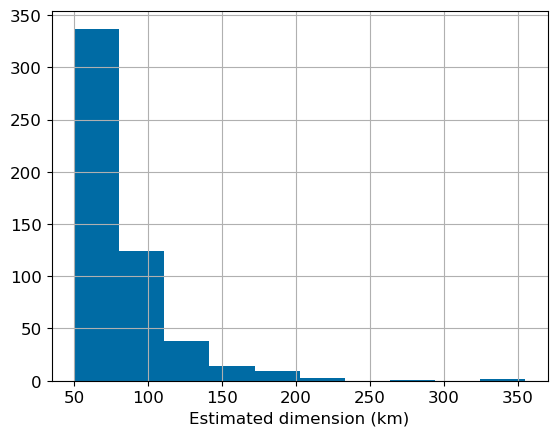

In [437]:
Scaling.magnitude_to_size(all_slowslip.catalog.mag,all_slowslip._stress_drop).hist()
plt.xlabel('Estimated dimension (km)')

In [438]:
T_pre = BACKGROUND_DURATION
buffer = BUFFER_TIME
T_event = REPRESENTATIVE_SSE_DURATION # all_slowslip.catalog['duration'].values/60/60/24 # days
W = SPACE_WINDOW_BIG # km
number_of_source_dimensions = 3 # for visualization purposes

# small wrapper function
def center_sequences_for_spatial_analysis(T, lag): 
    stack, w = center_sequences(time_window=T,space_window=W,lag=lag)[1:]
    I = ~np.any(np.abs(stack)>number_of_source_dimensions, axis=1)
    stack = stack[I,:]
    w = w[I]
    return [stack, w]

co_event_stack_combined, co_weights = center_sequences_for_spatial_analysis(T_event,0)
pre_event_stack_combined, pre_weights = center_sequences_for_spatial_analysis(T_pre,-T_pre/2 - T_event/2 - buffer)
post_event_stack_combined, post_weights = center_sequences_for_spatial_analysis(T_event,T_event/2)
    

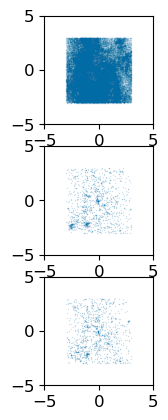

In [430]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 1, )

levels = np.linspace(0, 0.075, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.scatter(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], s=1, alpha=0.1, linewidths=0)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.scatter(co_event_stack_combined[:,0], co_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.scatter(post_event_stack_combined[:,0], post_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

for iax in [ax1,ax2,ax3]:
    iax.set(
        xlim=[-5,5],
        ylim=[-5,5],
        aspect='equal',
    )



In [431]:
# Define the bandwidth for smoothing
smoothing_bandwidth = 0.2

# Create the kernel density estimators
dens_pre_kde = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth/pre_event_stack_combined.T.std(ddof=1), weights=pre_weights)
dens_co_kde = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=co_weights)
dens_post_kde = gaussian_kde(post_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=post_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))



# Evaluate the density ratio on the grid
dens_co = dens_co_kde(grid_points.T).reshape(xx.shape)
dens_pre = dens_pre_kde(grid_points.T).reshape(xx.shape)
dens_post = dens_post_kde(grid_points.T).reshape(xx.shape)
density_differences = dens_co-dens_pre
density_ratio = dens_co/dens_pre

## Ploting ratios

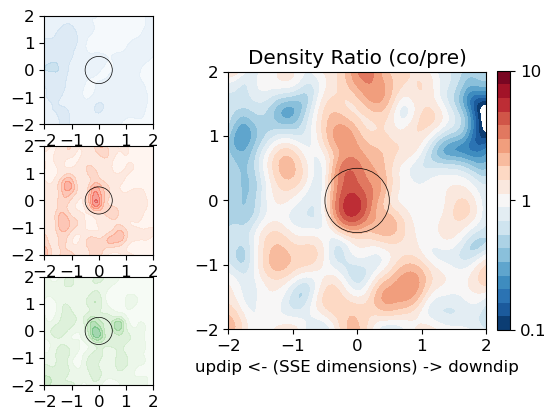

In [432]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2])

levels = np.linspace(0, 0.2, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.contourf(xx, yy, dens_pre, cmap='Blues',alpha=0.5, levels=levels)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.contourf(xx, yy, dens_post, cmap='Greens',alpha=0.5, levels=levels)


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1],  sharex=ax1)  # All rows, second column
ch = ax4.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1,1, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

cax4.set_ticks([-1, 0, 1])
cax4.set_ticklabels(['0.1', '1', '10'])
ax4.set(
    xlabel='updip <- (SSE dimensions) -> downdip',
    title='Density Ratio (co/pre)',
)

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    );

## Plotting differences

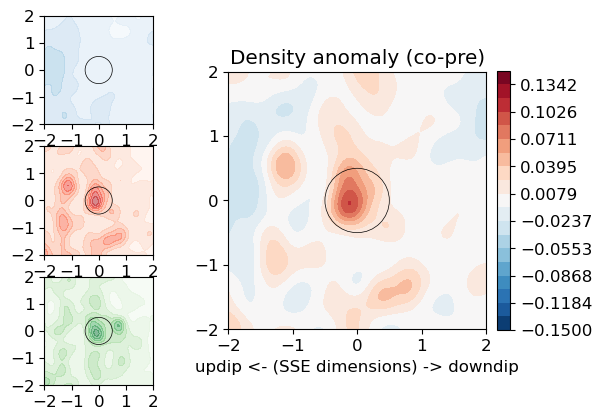

In [395]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2])

levels = np.linspace(0, 0.15, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.contourf(xx, yy, dens_pre, cmap='Blues',alpha=0.5, levels=levels)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.contourf(xx, yy, dens_post, cmap='Greens',alpha=0.5, levels=levels)


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1],  sharex=ax1)  # All rows, second column
ch = ax4.contourf(xx, yy, (density_differences), levels=np.linspace(-0.15,0.15, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

# cax4.set_ticks([-1, 0, 1])
# cax4.set_ticklabels(['0.1', '1', '10'])
ax4.set(
    xlabel='updip <- (SSE dimensions) -> downdip',
    title='Density anomaly (co-pre)',
)

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    );

## Frequency of anomalies

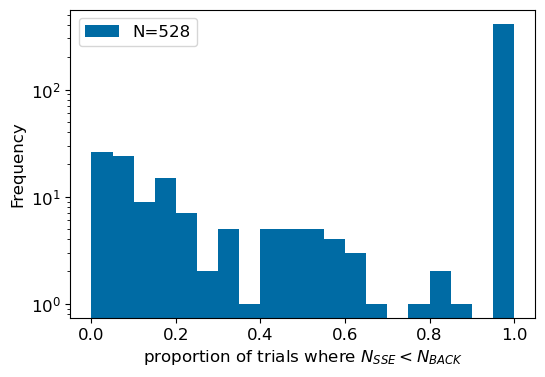

In [439]:
p_values, pre_time_lags, buffer_time_lags, co_time_lags = get_p_relative_to_back()
fig, ax = plt.subplots(1,1,figsize=(6,4))
th = 0.05
ax.hist(p_values, label=f'N={len(p_values)}', bins=20, log=True)
ax.set(xlabel='proportion of trials where $N_{SSE} < N_{BACK}$', ylabel='Frequency')
ax.legend()

Text(0.5, 0, 'number of earthquakes')

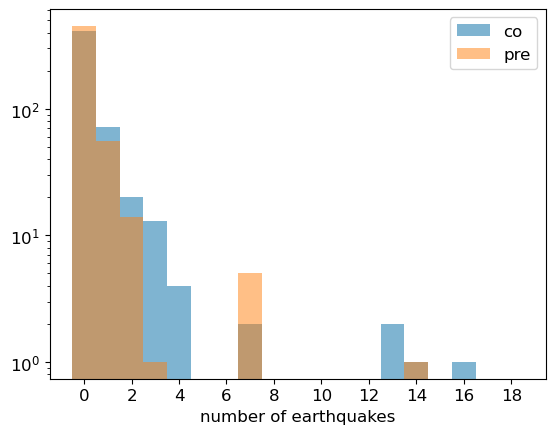

In [440]:
N = np.array([len(t) for t in co_time_lags])
N_pre = np.array([len(t) for t in pre_time_lags])
plt.hist(N,log=True, bins=np.arange(20)-0.5, alpha=0.5, label='co');
plt.hist(N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION),log=True, bins=np.arange(20)-0.5,alpha=0.5,label='pre');
plt.legend()
plt.xticks(np.arange(20)[::2]);
plt.xlabel('number of earthquakes')

In [441]:
(N>0).sum()/len(N)

0.2196969696969697

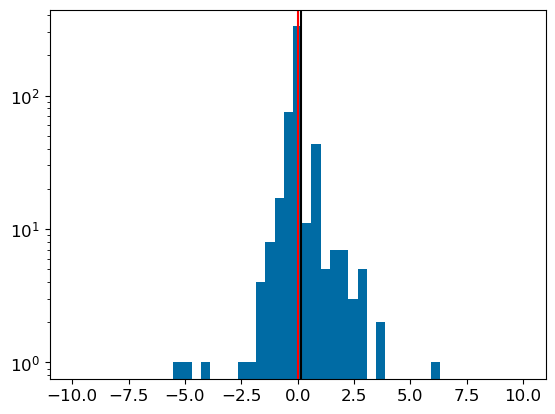

In [442]:
plt.hist((N-N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION)),bins=np.linspace(-10,10))
plt.yscale('log')
plt.axvline(c='r')
plt.axvline((N-N_pre/(BACKGROUND_DURATION/REPRESENTATIVE_SSE_DURATION)).mean(),c='k')

In [443]:
(p_values<th).sum()/len(p_values)

0.04924242424242424

In [444]:
## Look at some samples where the p-value is low - which we interpret as a significant increase in the number of events:
I = np.where(p_values < th)[0]

In [445]:
len(I)

26

In [446]:
def kstest_sample(array, index):
    return kstest(np.delete(array, index), array[index])

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_53425/3628621298.py:33: RuntimeWarning: divide by zero encountered in divide
  moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values


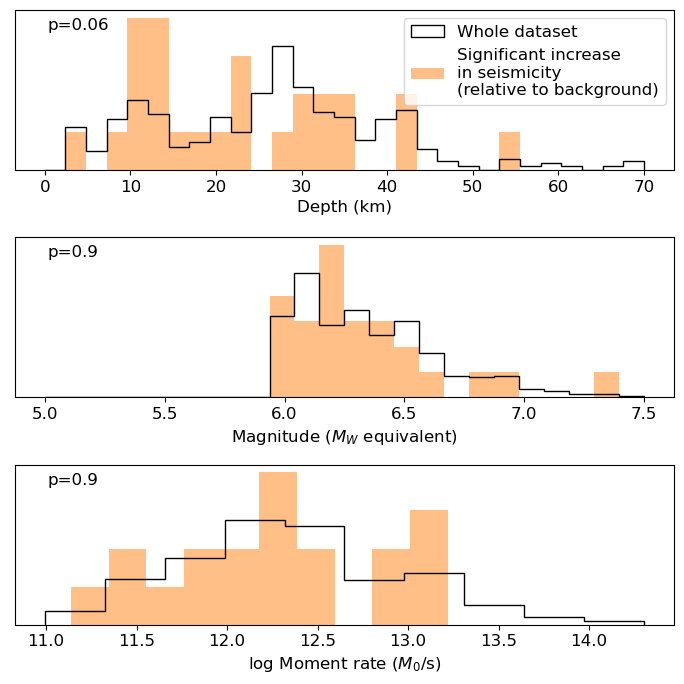

In [447]:
fig, AX = plt.subplots(3,1,figsize=(7,7))
whole_data_kwargs = dict(
    histtype='step',
    color='k',
    label='Whole dataset',
    density=True,
)
outlier_data_kwargs = dict(
     alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)', color='C1',density=True,
)

ax = AX[0]
bins = np.linspace(0,70,30)
ax.hist(all_slowslip.catalog.depth.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()

ax = AX[1]
bins = np.linspace(5,7.5,25)
ax.hist(all_slowslip.catalog.mag.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
)
ax = AX[2]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
ax.hist(np.log10(moment_rate[I_nan]), **whole_data_kwargs)
ax.hist(np.log10(moment_rate[I][I_nan[I]]), **outlier_data_kwargs)
ax.set_xlabel('log Moment rate ($M_0$/s)')


[
    iax.text(0.05,0.95, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='left') 
    for iax, iarray in zip(AX, [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

[iax.set_yticks([]) for iax in AX]

plt.tight_layout()
savefig('outliers')

### All places that have slow slip events seem to have some that are abnorally productive

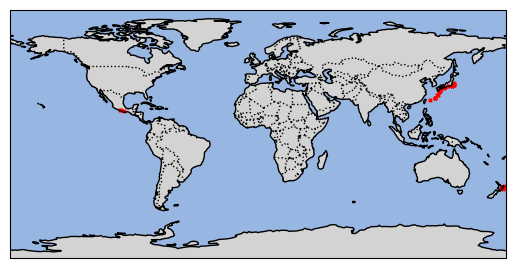

In [406]:
_, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")



ax.scatter(
    all_slowslip.catalog.lon.values[I],
    all_slowslip.catalog.lat.values[I],
    marker='x',
    s=5,
    c='r',
)
savefig('record_map')



In [407]:
all_slowslip.catalog.iloc[I].groupby('region').count().lat

region
Japan Trench      8
Mexico            3
Nankai Trough    11
New Zealand       7
Ryukyu Trench     9
Name: lat, dtype: int64

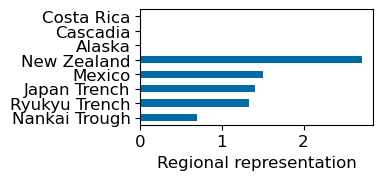

In [408]:
df_groups = ((all_slowslip.catalog.iloc[I].groupby('region').count().lat/all_slowslip.catalog.groupby('region').count().lat)/(sum(p_values < th)/len(p_values))).sort_values()
df_groups.plot(kind='barh', figsize=(3,1.5))
plt.ylabel('')
plt.xlabel('Regional representation')
savefig('regional bias')

A somewhat paradoxical results is that there are on average more earthquakes in the background period than during slow slip events. It is paradoxical because the periods with slow slip are nonetheless abnormal in having more seismicity than a random window in the preceding period. I beleive the only way to reconcile these two results is to suggest that, in general, seismicity prior to slow slip events tends to be quite clustered such that most window end up less productive the period with slow slip events with primarily is accopanied by a more reliable subtle increase in the background rate of seismicity. This might also indicate that in general the seismicity rate, accross then entire dataset is decreasing with time. This is inference is testable by looking at the seismicity rate in the period following the slow slip events.

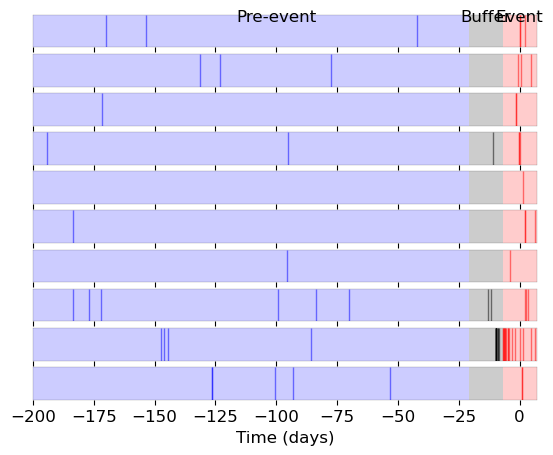

In [409]:
I = np.where(p_values<0.05)[0]
N = min(len(I),10)
t0 = -200
fig, ax = plt.subplots(N,1, figsize=(6.5,5), sharex=True)
for iax,i in zip(ax,I):
    shared_kwargs = dict(height=1, alpha=0.5, ax=iax)
    [sns.rugplot(dt[i],color=c, **shared_kwargs) for dt,c in zip([pre_time_lags, buffer_time_lags, co_time_lags], ['b','k','r'])]
    
    [
        iax.axvspan(x1,x2, color=c, alpha=0.2, lw=0) 
        for x1,x2,c in zip(
            [-T_pre-buffer-T_event/2, -T_event/2-buffer, -T_event/2],
            [-T_event/2-buffer, -T_event/2, T_event/2],
            ['b','k','r'],
        )
    ]
    iax.set(yticklabels=[], xlim=[t0, T_event/2], ylabel='', yticks=[])
    
[
    ax[0].text(x,1, va='bottom', ha='center', s=s) for x,s in zip(
        [0, -T_event/2-buffer/2, t0/2],
        ['Event', 'Buffer', 'Pre-event']
    )
]
ax[-1].set(xlabel='Time (days)')

[[x.set_linewidth(0.1) for x in iax.spines.values()] for iax in ax];
savefig('most_triggered_earthquakes')